In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Levenshtein import distance
from tqdm import tqdm
import networkx as nx

In [220]:
data_root = Path("./data")

In [221]:
account_booking_tr_df = pd.read_csv(data_root / "account_booking_train.csv")
account_booking_tr_df["transaction_date"] = pd.to_datetime(account_booking_tr_df["transaction_date"])
account_booking_tr_df

,transaction_reference_id,debit_credit_indicator,account_id,transaction_amount,transaction_currency,transaction_date
0,0ace8fca6ada96883ef2e823b5dea26b,CREDIT,25110,5249.26,GBP,2023-05-15
1,d52c4f1a546f5d784ee46a8f347ad607,DEBIT,27293,4481.50,GBP,2023-02-27
2,dac45362e7471a7fa2726c81adae8534,DEBIT,23088,1347.27,GBP,2023-03-18
3,2ee574398cd6c4a7f3e111447141550e,DEBIT,21641,9276.56,GBP,2023-07-15
4,c5154ea99a0ff84ba8e72217d34d3397,CREDIT,24233,8002.28,GBP,2024-01-12
...,...,...,...,...,...,...
11459,a90cf46dd436d86c133b58abebc5020e,CREDIT,27774,8018.26,GBP,2024-05-20
11460,fb3ecee0cc8eba410dac2e5a12c4ab41,DEBIT,29845,732.10,GBP,2023-02-07
11461,750f242d63c469c658fc9536839a5c78,CREDIT,25290,9564.51,GBP,2024-02-01
11462,1bbeb5347551c64222a5cab62cde1b4b,CREDIT,27115,5776.40,GBP,2023-05-24


In [222]:
account_booking_test_df = pd.read_csv(data_root / "account_booking_test.csv")
account_booking_test_df["transaction_date"] = pd.to_datetime(account_booking_test_df["transaction_date"])
account_booking_test_df

,transaction_reference_id,debit_credit_indicator,account_id,transaction_amount,transaction_currency,transaction_date
0,7b099be099de3e8a4b06f5a50ce41693,CREDIT,19331,8444.23,GBP,2023-08-05
1,efc916f9bd51695de9d4638adeb4711e,CREDIT,10020,4720.23,GBP,2024-04-07
2,fa427edc719b28aa82b5d407156aad7f,CREDIT,16341,944.02,GBP,2024-08-31
3,69c6762dbc5d193075a0a0721ccce1c1,DEBIT,13060,1743.42,GBP,2024-04-28
4,c17e2490dcf2993b1fa70187417786ce,CREDIT,11525,8396.21,GBP,2024-04-05
...,...,...,...,...,...,...
1511749,de433ce417d10c7e27fb87d53fd3b19e,DEBIT,11384,4734.23,GBP,2023-04-24
1511750,a5969a185558d6a0eeeeb523dda5c69e,DEBIT,17966,2443.53,GBP,2023-04-24
1511751,5f0e17b8519213ada7a27375961f5fba,CREDIT,12021,3424.78,GBP,2023-05-23
1511752,5ec0556e6ad998f73d22774d2d7e2db8,CREDIT,15379,9318.83,GBP,2024-07-03


In [245]:
external_parties_tr_df = pd.read_csv(data_root / "unparse_old.csv")
# drop na external_id
external_parties_tr_df = external_parties_tr_df.dropna(subset=["external_id"])
external_parties_tr_df["external_id"] = external_parties_tr_df["external_id"].astype(int)
external_parties_tr_df

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id,phone_indicator,parsed_titles,clean_name
0,04ff0d1c680189e3a80c92d86407f0f5,BENE,mary mith 107 107 angela brooks n. thomasfurt ...,mary mith,angela brooks,107 107,NaN,NaN,n. thomasfurt,NaN,bulgaria,GB49MYOB82127728573340,+181566067918486,50039037,1.0,NaN,mary mith
1,439ab0ad7380e6135ab2ff3fddd4a727,ORG,yesneia kim north michael 93971 koribati,yesneia kim,north michael,NaN,NaN,93971,koribati,NaN,NaN,NaN,+26962087342349,60044692,269.0,NaN,yesneia kim
2,00cac12d41191a84f9e31aa731a83512,ORG,w. roberson jr. 41010 rachel crossingapt. 923 ...,w. roberson jr.,rachel crossingapt.,41010 923,NaN,p2235417,thompsonshire amyport,NaN,NaN,GB08OTHR53515837682953,NaN,30008244,NaN,jr.,w. roberson
3,e4fba5f878dd3453e35973605a783a16,BENE,azquez-nelson co. suarez ports suite & 024 bri...,azquez-nelson co.,ports suite &,NaN,NaN,NaN,brittanyberg,NaN,bulgaria bulgaria,GB17VVGW66321494633280,NaN,40017944,NaN,co.,azquez-nelson
4,d03d7e4c31878b0255d39e8c3f0ab625,ORG,m.j. bytd iii 856 john lake s. glenn cocos (ke...,m.j. bytd iii,john lake s. glenn,856,NaN,125838276,cocos (keeling),islands,NaN,NaN,+2603371534,40012658,260.0,NaN,m.j. bytd iii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,7183d9c3700148c9527869948b685085,BENE,james alvarado jr. port james zambia,james alvarado jr.,james,NaN,NaN,NaN,port,NaN,zambia,GB72FLST90715739139871,+4194922033879822,35031814,41.0,jr.,james alvarado
11060,b47b9ed0a8cc9fcc4c21ac368fe79757,BENE,marcnguyen 234 price meadows robertmouth,marcnguyen,price meadows,234,NaN,NaN,robertmouth,NaN,NaN,GB64SFWQ57121822291812,NaN,35003780,NaN,NaN,marcnguyen
11061,d61ff2b0184f32ad0021a313c6112b2e,ORG,joseph davis 14131 taylor villages apt. 764 s....,joseph davis,taylor villages apt. 764 kimberlymouth,14131,NaN,99190 p5676812,s. gibraltar,NaN,NaN,GB36XGTI64012968550973,+4118784377081,30014262,41.0,NaN,joseph davis
11062,bec335b1b1bad8c55b7dce549cfd8de0,ORG,gonzalezltd 94129lozano cape,gonzalezltd,NaN,NaN,NaN,94129lozano,cape,NaN,NaN,NaN,NaN,10359417,NaN,NaN,gonzalezltd


In [246]:
external_parties_test_df = pd.read_csv(data_root / "external_parties_test.csv")
external_parties_test_df

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone
0,8f71ed0a819236b141978defe9a98700,BENE,therese humphrey 6223 john brokos wilvoxside 7...,therese humphrey,john brokos,6223,NaN,275897045,wilvoxside,NaN,NaN,NaN,NaN
1,dc9be336b81b971c04ca98ccdf99d51e,ORG,holly dudley 1151 doug las islands danniellesi...,holly dudley,doug las islands danniellesie,1151,NaN,72672946,lewisburgh,NaN,NaN,GB17FHFZ32055696556303,(0041)8078 074491
2,29c8ed895b8a220121168158a7447773,ORG,mcfarlan dknc 74099 joseph inlet ramirezport 7...,mcfarlan dknc,joseph inlet,NaN,NaN,74099 79351,ramirezport,NaN,brazil,GB18NWMC17588581045699,NaN
3,38ee5d04ad50ddf5f6abc67017201548,BENE,jamie cooper 50019 austin light johnbury saudi...,jamie cooper,austin light,50019,NaN,p3848887,johnbury,saudi arabia,NaN,GB57DWGJ37547997137031,NaN
4,eef4f720e71bda0a6f1e7caa21a2c98c,ORG,"fernandez, frost and gonzalez 6776 thomas cres...","fernandez, frost and gonzalez",thomas crescent apt.,6776 868,NaN,80966,michaelberg new jasmine,NaN,united states minor outlying islands,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481667,a3b0502a9917c0da0c0343055d434c8f,ORG,allen-gonzalez west melissa 75288 tonga,allen-gonzalez,west melissa,NaN,NaN,75288,NaN,NaN,tonga,NaN,NaN
1481668,38aac541d4b2cef7c05b584abfcca494,ORG,mccarthh llc (malvinas) 11926 alvarado ranch s...,mccarthh llc,(malvinas) alvarado ranch suite,11926 928,NaN,NaN,jacobbury,falkland islands,NaN,GB93CKKF54044020401473,(+351) +14559941899x22107
1481669,28f3dfc3160bae3b92c7c42e1082cf43,ORG,garcia-moore 2742 johnson bridge terrimouth la...,garcia-moore,johnson bridge,2742 40037,NaN,p8700123,terrimouth lake saeahmouth,bahamas,NaN,GB95BWYC19345731923206,(0 041)6205853864
1481670,39f8569b0ced6d11fad95d628dd05d6a,ORG,santiago-oconnor 748 chang fields williamstad ...,santiago-oconnor,chang fields,748,NaN,31646,williamstad,NaN,algeria,GB27ROXX78104146280676,NaN


<Figure size 640x480 with 0 Axes>

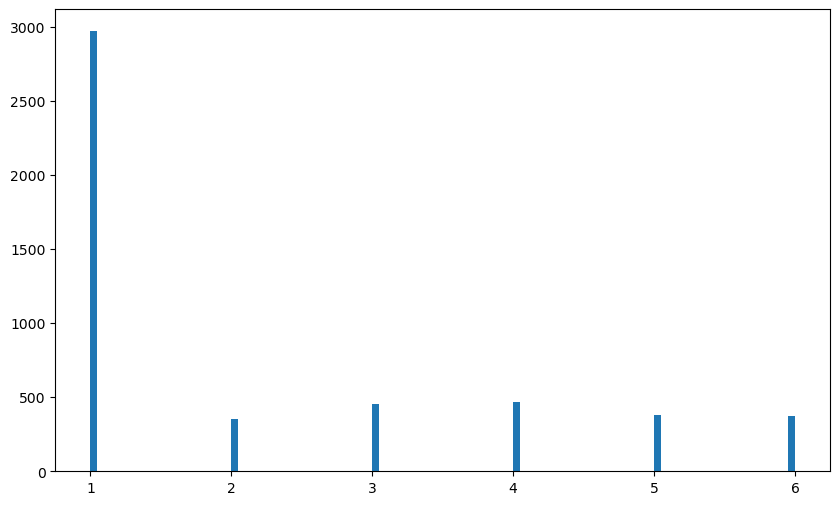

<Figure size 640x480 with 0 Axes>

In [247]:
external_parties_tr_df["external_id"].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(external_parties_tr_df["external_id"].value_counts(), bins=100)
plt.figure()

In [248]:
pairs_ids = external_parties_tr_df["external_id"].value_counts()
pairs_ids = pairs_ids[pairs_ids > 1]
pairs_ids

external_id
25024904    6
35003780    6
25039829    6
35003648    6
25010621    6
           ..
40019602    2
90023735    2
40004777    2
90012416    2
90021713    2
Name: count, Length: 2029, dtype: int64

In [249]:
external_id = pairs_ids.index[5]
external_parties_tr_df[external_parties_tr_df["external_id"] == external_id]

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id,phone_indicator,parsed_titles,clean_name
3402,e947caa0c8b36c4c41f7385dc0ae5948,ORG,martinezplc plc 482 mary mountains lake michel...,martinezplc plc,mary mountains lake,482,NaN,NaN,michellefurt,NaN,NaN,NaN,+568254745079,35005273,56.0,NaN,martinezplc plc
4565,b355424137886f6faf3d6afd51435207,BENE,martinezplc plc 6297 jeffrey underpass wilsonb...,martinezplc plc,jeffrey underpass,6297,NaN,NaN,wilsonborough,NaN,zimbabwe,GB67ORER58361188575948,+8254745079,35005273,82.0,NaN,martinezplc plc
6564,f617e18843eca278ff17f896990935ca,ORG,martinezplc plc 708 cooper drives suite 067 so...,martinezplc plc,cooper drives suite jamesstad,708,NaN,53553,south,NaN,egypt,GB67ORER58361188575948,+8254745079,35005273,82.0,NaN,martinezplc plc
7503,b52dc570e1c334eefa56686de74a37de,ORG,martinezplc plc francoshire 96360 saudi arabia,martinezplc plc,francoshire,NaN,NaN,96360,NaN,NaN,saudi arabia,NaN,+8254745079,35005273,82.0,NaN,martinezplc plc
7919,3f27eeda4615babd7c5ba0b39a39ea30,BENE,martinezplc plc poland 0702 escobar manor apt....,martinezplc plc,NaN,NaN,NaN,67049,escobar manor,apt.,NaN,GB67ORER58361188575948,+568254745079,35005273,56.0,NaN,martinezplc plc
9758,a4300a18733d8e44a5d869ee3d35b045,BENE,martinezplc plc johnson locks apt. 869 w. alli...,martinezplc plc,johnson locks apt. allison,869,NaN,NaN,w.,mauritius,NaN,NaN,+568254745079,35005273,56.0,NaN,martinezplc plc


## Evaluation

In [250]:
def indices_of_value(sorted_array, value):
    start_index = np.searchsorted(sorted_array, value, side="left")
    end_index = np.searchsorted(sorted_array, value, side="right")
    return start_index, end_index

In [251]:
def match_with_base(true_ids, assigned_ids):
    sorted_pairs = sorted(zip(true_ids, assigned_ids), key=lambda x: x[0])
    sorted_true_ids = np.array([pair[0] for pair in sorted_pairs])
    assigned_ids_sorted_pair = np.array([pair[1] for pair in sorted_pairs])
    num_all_total_pairs = 0
    num_all_matched_pairs = 0
    for true_id in np.unique(sorted_true_ids):
        start_index, end_index = indices_of_value(sorted_true_ids, true_id)
        num_true_occurrences = end_index - start_index
        num_total_pairs = num_true_occurrences * (num_true_occurrences - 1) // 2
        num_matched_pairs = 0
        sliced_assigned_ids = assigned_ids_sorted_pair[start_index:end_index]
        for assigned_id in np.unique(sliced_assigned_ids):
            num_assigned_occurrences = (sliced_assigned_ids == assigned_id).sum()
            num_matched_pairs += (
                num_assigned_occurrences * (num_assigned_occurrences - 1) // 2
            )
        num_all_total_pairs += num_total_pairs
        num_all_matched_pairs += num_matched_pairs
    return float(num_all_matched_pairs / num_all_total_pairs) if num_all_total_pairs > 0 else 0


def f1_score(true_ids, assigned_ids):
    rc = match_with_base(true_ids, assigned_ids)
    pr = match_with_base(assigned_ids, true_ids)
    return 2 * rc * pr / (rc + pr) if rc + pr > 0 else 0, rc, pr


true_ids = pd.Series([1, 1, 1, 1, 2, 2, 2])
assigned_ids = pd.Series([10, 10, 12, 12, 13, 13, 12])
print(f1_score(true_ids, assigned_ids))

(0.42857142857142855, 0.3333333333333333, 0.6)


## Initial Merging

In [252]:
def init_df(df):
    df = df.copy(deep=True)
    df["assigned_id"] = np.arange(len(df))
    print("init len", len(df))
    return df

In [253]:
def merge_ids(parties_df, ids_to_merge, col_name="assigned_id"):
    id = np.array(ids_to_merge).min()
    parties_df.loc[parties_df[col_name].isin(ids_to_merge), col_name] = id
    return parties_df

In [254]:
def pipeline(df, pipeline):
    for step in pipeline:
        df = step(df)
    return df

In [255]:
def match_based_on_sortable_col(df, col):
    df = df.sort_values(col)
    start_i = 0
    with tqdm(total=len(df)) as pbar:
        while start_i < len(df):
            end_i = start_i + 1
            while end_i < len(df) and (df[col].iloc[start_i] == df[col].iloc[end_i]):
                end_i += 1
            if end_i - start_i > 1:
                assigned_ids = df["assigned_id"].iloc[start_i:end_i].tolist()
                df = merge_ids(df, assigned_ids)
            pbar.update(end_i - start_i)
            start_i = end_i
    return df

In [256]:
df = pipeline(
    external_parties_tr_df,
    [
        init_df,
        lambda df: match_based_on_sortable_col(df, "party_iban"),
    ],
)
print(f1_score(df["external_id"], df["assigned_id"]))
print(len(df["assigned_id"].unique()))

init len 11064


100%|██████████| 11064/11064 [00:00<00:00, 26318.37it/s]


(0.5520530900041477, 0.38126611286164425, 1.0)
8330


In [257]:
df = pipeline(
    external_parties_tr_df,
    [
        init_df,
        lambda df: match_based_on_sortable_col(df, "party_iban"),
        lambda df: match_based_on_sortable_col(df, "party_phone"), # TODO: phone indicator
    ],
)
print(f1_score(df["external_id"], df["assigned_id"]))
print(len(df["assigned_id"].unique()))
df.sort_values("external_id")
df

init len 11064


100%|██████████| 11064/11064 [00:00<00:00, 40086.19it/s]


(0.6799640780829039, 0.5151102835863649, 1.0)
7717


,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id,phone_indicator,parsed_titles,clean_name,assigned_id
9652,16b1d548adac62179a0019a702bf6ac4,ORG,christine gibso n diazfrt benderfort benderfor...,christine gibso n,n diazfrt benderfort benderfort,NaN,NaN,78678,saint helena,NaN,NaN,GB69HGOM71538395627258,+100122249158126606,90009175,1.0,NaN,christine gibso n,9652
6229,cfc5651b2f837d16c6cbff11d37f3c0e,ORG,dr. joh nnelson sr. 30589 frazier common w. sa...,dr. joh nnelson sr.,frazier common w. sandrabury,30589,NaN,NaN,port brandonchester,NaN,zambia,GB29BHRQ41531564754017,+10017373782272,30021874,1.0,"dr.,sr.",joh nnelson,6229
3128,fceabeef6e7d76337d4502867dfb8131,BENE,tsacey iii 158746537 848 navarro islands s. ma...,tsacey iii,navarro,158746537,NaN,848,islands s. matthew,french guiana,NaN,GB33GKES86362624099102,+11215891465996501,25024311,1.0,NaN,tsacey iii,46
46,5e27a433a20b7239cf3ada3dc34995cf,BENE,hemilton stacey guiana 848 navarro islands s. ...,hemilton stacey,guiana,848,NaN,NaN,navarro islands s. matthew,NaN,french,GB33GKES86362624099102,+11215891465996501,25024311,1.0,NaN,hemilton stacey,46
5873,c606b3c3a88c1fac3c734c257602e4d8,BENE,stacey hamilton hamilton 848 navarro navarro i...,stacey hamilton hamilton,navarro navarro islands,848,NaN,NaN,sluth matthew frnech,NaN,guiana,GB33GKES86362624099102,+11215891465996501,25024311,1.0,NaN,stacey hamilton hamilton,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11033,ead06e38091aa5c30907f978f9d2f7a0,BENE,april patterson man 987 robert shoal apt. 977 ...,april patterson,robert shoal apt. allenfort,987,NaN,NaN,brianfurt,isle of,NaN,NaN,NaN,25020873,NaN,NaN,april patterson,11033
11038,afe7cea435b4e73130209c7047ef4308,BENE,obrien anc sons 9437 garcia ports suyte 401 po...,obrien anc sons,garcia ports suyte,9437 401,NaN,45472,port christineport south megan,NaN,NaN,NaN,NaN,10599523,NaN,NaN,obrien anc sons,11038
11049,c9312f68ba6f28d0e72d24ca4b8f1147,BENE,john simpson 372 brown cliff apt. 677 north ja...,john simpson,brown cliff apt.,372 677,NaN,10195,north james,NaN,NaN,NaN,NaN,20001819,NaN,NaN,john simpson,11049
11053,b1ad050dcb53ebf3ba9b55241999ca08,BENE,"nelson, brooks and harrison 06230 hannah hollo...",nelson brooks and harrison,hannah hollow lake,NaN,NaN,27650,shannon lebanon,NaN,NaN,NaN,NaN,10359096,NaN,NaN,nelson brooks and harrison,11053


In [258]:
df = pipeline(
    external_parties_tr_df,
    [
        init_df,
        lambda df: match_based_on_sortable_col(df, "party_iban"),
        lambda df: match_based_on_sortable_col(df, "party_phone"),
        lambda df: match_based_on_sortable_col(df, "clean_name"),
    ],
)
print(f1_score(df["external_id"], df["assigned_id"]))
print(len(df["assigned_id"].unique()))
df.sort_values("external_id")
df.to_csv("external_parties_merged.csv")

init len 11064


100%|██████████| 11064/11064 [00:00<00:00, 24391.65it/s]


(0.881120999810642, 0.8330707533657977, 0.9350534522948316)
5857


## Check Non Matched Pairs

In [237]:
not_matched_dfs = []
unique_external_id = df["external_id"].unique()
for external_id in unique_external_id:
    sub_df = df[df["external_id"] == external_id]
    unique_assigned_id = sub_df["assigned_id"].unique()
    if len(unique_assigned_id) > 1:
        not_matched_dfs.append(sub_df)
len(not_matched_dfs)

594

In [238]:
not_matched_dfs[10]

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id,phone_indicator,parsed_titles,clean_name,abbreviated_name,assigned_id
7099,b47b81e2dd62821fa45930c44c5d2d9c,BENE,a. mrphy 05127 schultz path apt. 789 south che...,a. mrphy,schultz path apt.,NaN,NaN,NaN,south chelseamouth,NaN,ecuador,GB90CUSW56304462740661,+390019347520688,25006498,39.0,NaN,a. mrphy,a. mrphy,7099
2349,1c8dc86aca4db4e6eec211d306399a57,ORG,alexander murphy 05127 schultz path apt. 789 s...,alexander murphy,schultz path apt.,NaN,NaN,NaN,south chelseamouth,NaN,ecuador,NaN,NaN,25006498,NaN,NaN,alexander murphy,a. murphy,2349
9468,13818a7bdfe507596107848019ed2e70,ORG,alexender alexender murphy ii 05127 schultz pa...,alexender alexender murphy ii,schultz path apt.,NaN,NaN,NaN,south chelseamouth,NaN,ecuador,GB90CUSW56304462740661,+19347520688,25006498,1.0,NaN,alexender murphy,a. murphy,7099


## Graph Algorithms

In [239]:
account_booking_df = account_booking_tr_df

In [240]:
edges_df = pd.merge(
    account_booking_df,
    df,
    on="transaction_reference_id",
    how="inner",
)
del edges_df["transaction_reference_id"]
del edges_df["transaction_currency"]
del edges_df["party_role"]
del edges_df["party_info_unstructured"]
del edges_df["parsed_name"]
del edges_df["parsed_address_street_name"]
del edges_df["parsed_address_street_number"]
del edges_df["parsed_address_unit"]
del edges_df["parsed_address_postal_code"]
del edges_df["parsed_address_city"]
del edges_df["parsed_address_state"]
del edges_df["parsed_address_country"]
del edges_df["party_iban"]
del edges_df["phone_indicator"]
del edges_df["party_phone"]
del edges_df["parsed_titles"]
del edges_df["clean_name"]
edges_df

,debit_credit_indicator,account_id,transaction_amount,transaction_date,external_id,abbreviated_name,assigned_id
0,CREDIT,25110,5249.26,2023-05-15,35010896,g.,4106
1,DEBIT,27293,4481.50,2023-02-27,35020711,j.,3486
2,DEBIT,23088,1347.27,2023-03-18,35024310,a.,4481
3,DEBIT,21641,9276.56,2023-07-15,10084859,y.,6029
4,CREDIT,24233,8002.28,2024-01-12,20010362,w. michael,3382
...,...,...,...,...,...,...,...
11059,CREDIT,27774,8018.26,2024-05-20,40006533,v. holt,9927
11060,DEBIT,29845,732.10,2023-02-07,40021118,b. henderson,2248
11061,CREDIT,25290,9564.51,2024-02-01,25023678,p.,1862
11062,CREDIT,27115,5776.40,2023-05-24,35012535,a. warren,965


In [241]:
nodes = []
edges = []
for _, row in edges_df.iterrows():
    nodes.append((row["account_id"], "known"))
    nodes.append((row["assigned_id"], "unknown"))
    if row["debit_credit_indicator"] == "DEBIT":
        edges.append(
            (
                row["account_id"],
                row["assigned_id"],
                row["transaction_amount"],
                row["transaction_date"],
            )
        )
    else:
        edges.append(
            (
                row["assigned_id"],
                row["account_id"],
                row["transaction_amount"],
                row["transaction_date"],
            )
        )

In [242]:
g = nx.DiGraph()
g.add_weighted_edges_from(edges)
g

ValueError: too many values to unpack (expected 3)